In [1]:
wd ='C:/Users/karan/OneDrive/Desktop/EMA_runs/'

In [2]:
from ema_workbench.connectors.vensim import (VensimModel)

C:\Users\karan\anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:29: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)
C:\Users\karan\anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:34: ImportWarning: simio connector not available
  warnings.warn("simio connector not available", ImportWarning)


In [3]:
from ema_workbench import (
    RealParameter,
    TimeSeriesOutcome,
    ema_logging,
    perform_experiments,
    MultiprocessingEvaluator,
    CategoricalParameter
)

In [4]:
Trust_model = VensimModel('Vensim', wd = wd,
    model_file=wd+'ExplorationTrustSystem_KPoeran.vpmx')

In [5]:
Trust_model.outcomes = [
    TimeSeriesOutcome("Trust Distributor in Client"),
    TimeSeriesOutcome("Trust Client in Distributor"),
]

In [6]:
Trust_model.uncertainties = [
          RealParameter("Initial Trust Fraction Distributor", 0, 1),
          RealParameter("Initial Trust Fraction Client", 0, 1),
          RealParameter("Initial Knowledge Client", 0.1, 0.5),
          RealParameter("Learning Rate", 0.001, 0.005),
          RealParameter("Trust Building Delay", 1, 4),
          RealParameter("Knowledge Processing Delay",1, 4),
          RealParameter("Initial Knowledge Distributor", 0.5 , 0.9),
          RealParameter("Knowledge Loss Factor", 0.1, 0.25),
          RealParameter("Information transmission delay about correct ATBs", 1, 4),
          RealParameter("Material Delivery Time", 1, 26),
          RealParameter("Yearly Material Usage", 900, 1000),
    
          CategoricalParameter('Switch Correction Capacity Lever', (0,1)),
          CategoricalParameter('Switch Job Rotation Cycle Lever', (0,1)),
          CategoricalParameter('Switch Target Delivery Delay Lever', (0,1))
        
]

In [7]:
nr_experiments = 1000
with MultiprocessingEvaluator(Trust_model) as evaluator:
    results = perform_experiments(Trust_model, nr_experiments, evaluator=evaluator)



100%|██████████████████████████████████████| 1000/1000 [01:00<00:00, 16.40it/s]


In [8]:
exp, out = results

In [9]:
from ema_workbench import save_results
save_results(results, r'C:/Users/karan/OneDrive/Desktop/EMA_runs/1000runs.tar.gz')

C:\Users\karan\anaconda3\lib\site-packages\ema_workbench\em_framework\outcomes.py:539: UserWarning: still to be tested!!
  warnings.warn("still to be tested!!")


In [10]:
from __future__ import (absolute_import, print_function, division, unicode_literals)
from ema_workbench import (Model, RealParameter, ScalarOutcome, Constant, Policy, perform_experiments, ema_logging,
TimeSeriesOutcome, perform_experiments, save_results, load_results)
from ema_workbench.analysis import (feature_scoring)
from ema_workbench.analysis.pairs_plotting import (pairs_lines, pairs_scatter, pairs_density)
from ema_workbench.connectors.vensim import (VensimModel) #LookupUncertainty,VensimModel, VensimModelStructureInterface)
from ema_workbench.em_framework import CategoricalParameter
from ema_workbench.analysis.plotting import lines, envelopes, kde_over_time, multiple_densities
from ema_workbench.analysis import clusterer, plotting, Density
from ema_workbench.analysis import scenario_discovery_util as sdutil
import numpy as np
import seaborn as sns #; sns.set(style="ticks", color_codes=True)
import pandas as pd
import matplotlib.pyplot as plt
TIME_LABEL = 'Time'
from ema_workbench.analysis.plotting_util import prepare_data, COLOR_LIST, simple_kde, group_density,\
plot_envelope, simple_density, do_titles,\
do_ylabels, TIME
import ema_workbench.analysis.plotting_util as plt_util
from ema_workbench.analysis.plotting import group_by_envelopes, single_envelope, plot_lines_with_envelopes
from ema_workbench.analysis.pairs_plotting import pairs_scatter, pairs_density
from ema_workbench.analysis import pairs_plotting
from ema_workbench.analysis import (get_ex_feature_scores,
RuleInductionType)
import ema_workbench.analysis.cart as cart

In [11]:
def find_colors(ax):
    color_converter = ColorConverter()
    all_colors = []
    for line in ax.get_lines():
        orig_color = line.get_color()
        if orig_color not in all_colors:
            all_colors.append(orig_color)
    return all_colors


In [12]:
def save_fig(fig, dir, name,
            dpi=300):
    '''save a high res and a low res version of the figure in the specified
    directory, using the label i.

    Parameters
    ----------

    fig : a Figure instance
    dir : str
    the directory where figures are to be saved
    name : str
    dpi : int, optional
    '''
    fig.savefig('{}/fig_{}_{}dpi.png'.format(dir, name, dpi), dpi=dpi,
                bbox_inches='tight', format='png')


In [13]:
def change_fontsize(fig, fs=11.5):
    '''Change fontsize of figure items to specified size'''
    for ax in fig.axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                    ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fs)
        try:
            parasites = ax.parasites
        except AttributeError:
            pass
        else:
            for parisite in parasites:
                for axis in parisite.axis.values():
                    axis.major_ticklabels.set_fontsize(fs)
                    axis.label.set_fontsize(fs)
            for axis in ax.axis.values():
                axis.major_ticklabels.set_fontsize(fs)
                axis.label.set_fontsize(fs)
        if ax.legend_ != None:
            for entry in ax.legend_.get_texts():
                entry.set_fontsize(fs)
        for entry in ax.texts:
            entry.set_fontsize(fs)
        for entry in ax.tables:
            entry.set_fontsize(fs)

In [14]:
def nice_lines (exp,out,out_to_show,
                group_by= None,
                density=None,title=None,
                exp_to_show = None,
                grouping_specifiers = None,
                legend = False,
                paradigm = '',
                convert_to_t = False,
                convert_to_kt = False,
                convert_to_Mt = False,
                zero = False ,
                yupperlim = None,
                ylabel = False,
                alpha = None,
                sizex = None,
                sizey = None):
    if convert_to_t == True:
        out[title] = out[out_to_show]/2204.622620
        lines(experiments = exp, outcomes = out,
                experiments_to_show = exp_to_show,
                outcomes_to_show = title, legend = legend,
                group_by = group_by, density = density,
                grouping_specifiers = grouping_specifiers)
    elif convert_to_kt == True:
        out[title] = out[out_to_show]/2204622.620
        lines(experiments = exp, outcomes = out,
            experiments_to_show = exp_to_show,
            outcomes_to_show = title,legend = legend,
            group_by = group_by, density = density,
            grouping_specifiers = grouping_specifiers)
    elif convert_to_Mt == True:
        out[title] = out[out_to_show]/2204622620
        lines(experiments = exp, outcomes = out,
            experiments_to_show = exp_to_show,
            outcomes_to_show = title,legend = legend,
            group_by = group_by, density = density,
            grouping_specifiers = grouping_specifiers)
    else:
        out[title] = out[out_to_show]
        lines(experiments = exp, outcomes = out,
                experiments_to_show = exp_to_show,
                outcomes_to_show = title,legend = legend,
                group_by = group_by, density = density,
                grouping_specifiers = grouping_specifiers)
    fig = plt.gcf()
    fig.set_size_inches(6,3)
    if sizex:
        fig.set_size_inches(sizex,sizey)
    ax = fig.get_axes()
    if zero == True:
        ax[0].set_ylim([0,yupperlim])
    ax[0].set_xticklabels(labels_time)
    if ylabel:
        ax[0].set(ylabel=ylabel)
    if alpha:
        for line in ax[0].get_lines():
            line.set_alpha(alpha)
    short_title = title.replace(" ","")
    change_fontsize(fig)
    sns.despine()
    save_fig(fig,wd,paradigm+short_title)
    # fig.savefig(wd+paradigm+short_title+'.jpg')
    plt.show()

In [15]:
import matplotlib.pyplot as plt
labels_time = [0,20, 40, 60, 80, 100, 120]
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['legend.frameon'] = False
# Call each time:
# sns.despine()

C:\Users\karan\AppData\Local\Temp\ipykernel_6756\2777617911.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels_time)


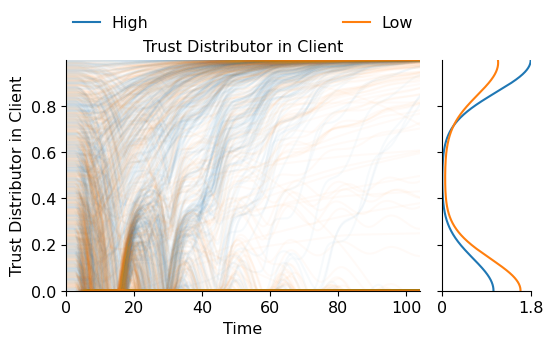

In [16]:
nice_lines(exp,out,out_to_show = 'Trust Distributor in Client',
              
          
          group_by = 'Switch Correction Capacity Lever', legend = True,
          grouping_specifiers = {'Low': 0, 'High' : 1},
          density = Density.KDE, zero = True,
          ylabel= 'Trust Distributor in Client',
          title = 'Trust Distributor in Client', alpha = 0.03)

C:\Users\karan\AppData\Local\Temp\ipykernel_6756\2777617911.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels_time)


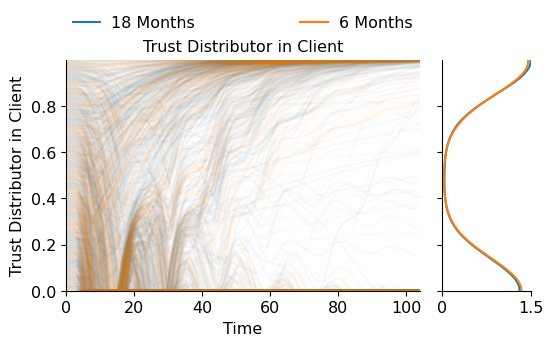

In [17]:
nice_lines(exp,out,out_to_show = 'Trust Distributor in Client',
              
          
          group_by = 'Switch Job Rotation Cycle Lever', legend = True,
          grouping_specifiers = {'18 Months': 0, '6 Months' : 1},
          density = Density.KDE, zero = True,
          ylabel= 'Trust Distributor in Client',
          title = 'Trust Distributor in Client', alpha = 0.03)

C:\Users\karan\AppData\Local\Temp\ipykernel_6756\2777617911.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels_time)


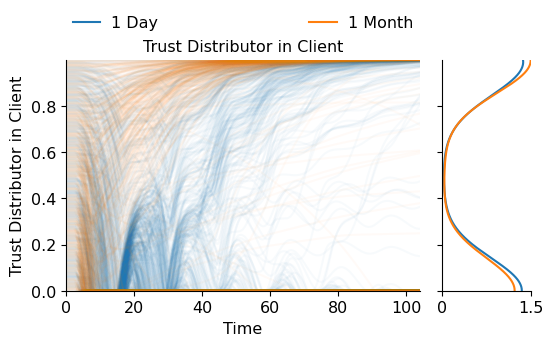

In [18]:
nice_lines(exp,out,out_to_show = 'Trust Distributor in Client',
              
          
          group_by = 'Switch Target Delivery Delay Lever', legend = True,
          grouping_specifiers = {'1 Day': 0, '1 Month' : 1},
          density = Density.KDE, zero = True,
          ylabel= 'Trust Distributor in Client',
          title = 'Trust Distributor in Client', alpha = 0.03)

The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
C:\Users\karan\AppData\Local\Temp\ipykernel_6756\2777617911.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels_time)


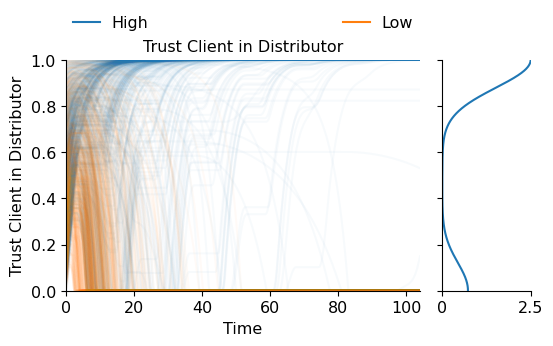

In [19]:
nice_lines(exp,out,out_to_show = 'Trust Client in Distributor',
              
          
          group_by = 'Switch Correction Capacity Lever', legend = True,
          grouping_specifiers = {'Low': 0, 'High' : 1},
          density = Density.KDE, zero = True,
          ylabel= 'Trust Client in Distributor',
          title = 'Trust Client in Distributor', alpha = 0.03)

C:\Users\karan\AppData\Local\Temp\ipykernel_6756\2777617911.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels_time)


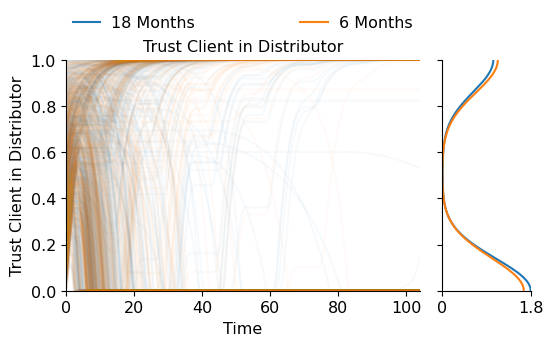

In [20]:
nice_lines(exp,out,out_to_show = 'Trust Client in Distributor',
              
          
          group_by = 'Switch Job Rotation Cycle Lever', legend = True,
          grouping_specifiers = {'18 Months': 0, '6 Months' : 1},
          density = Density.KDE, zero = True,
          ylabel= 'Trust Client in Distributor',
          title = 'Trust Client in Distributor', alpha = 0.03)

C:\Users\karan\AppData\Local\Temp\ipykernel_6756\2777617911.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels_time)


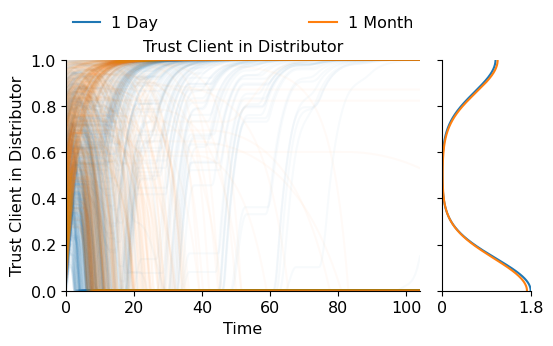

In [21]:
nice_lines(exp,out,out_to_show = 'Trust Client in Distributor',
              
          
          group_by = 'Switch Target Delivery Delay Lever', legend = True,
          grouping_specifiers = {'1 Day': 0, '1 Month' : 1},
          density = Density.KDE, zero = True,
          ylabel= 'Trust Client in Distributor',
          title = 'Trust Client in Distributor', alpha = 0.03)